# 3:2

In [1]:
import rebound
import reboundx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy import constants as c
from astropy import units as u
from tqdm import tqdm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.style as mplstyle
mplstyle.use('fast')

In [2]:
import requests
import json
import numpy as np

# ['5','6','7','8','9'] = ["JUPITER BARYCENTER", "SATURN BARYCENTER", "URANUS BARYCENTER", "NEPTUNE BARYCENTER", "PLUTO BARYCENTER"]
planets = ['5','6','7','8','9']
orbital_elements = []
for planet in planets:
    # Construct the API URL
    # Date is 2004-06-01
    url = f"https://ssd.jpl.nasa.gov/api/horizons.api?format=text&COMMAND='{planet}'&OBJ_DATA='YES'&MAKE_EPHEM='YES'&EPHEM_TYPE='ELEMENT'&CENTER='500@0'&START_TIME='2004-06-01'&STOP_TIME='2004-06-02'&STEP_SIZE='1%20d'&CSV_FORMAT='YES&OUT_UNITS='AU-D'"
    # Send an HTTP GET request to the API
    response = requests.get(url)
    
    # List: [EC, QR, IN, OM, W , Tp ,N , MA, TA ,A , AD, PR]
    #       [0   1   2   3   4   5   6   7   8   9   10  11]
    stri = response.text

    #Get just the data from string ####consider using json instead####
    data = (((stri.split('$$SOE\n')[1]).split('\n$$EOE')[0]).split('\n')[0][52:]).split(',')

    # Extract the orbital elements from the response
    a = eval(data[9]) # Semi-major axis (in AU)
    e = eval(data[0]) # Eccentricity
    inc = eval(data[2]) # Inclination (in degrees)
    Omega = eval(data[3]) # Longitude of the ascending node (in degrees)
    omega = eval(data[4]) # Argument of perihelion (in degrees)
    f = eval(data[8]) # True anomaly (in degrees)

    # Append the orbital elements to empty list
    orbital_elements.append({"a": a, "e": e, "inc": inc, "Omega": Omega, "omega": omega, "f": f})

# Convert degrees to radians
for elem in orbital_elements:
    elem["inc"] = np.deg2rad(elem["inc"])
    elem["omega"] = np.deg2rad(elem["omega"])
    elem["Omega"] = np.deg2rad(elem["Omega"])
    elem["f"] = np.deg2rad(elem["f"])

In [14]:
import rebound
import numpy as np
from tqdm import tqdm

# Get L7 Model 
L7_res = pd.read_csv('L7MODEL/resonant.dat',skiprows=28,sep='\s+',header=0)
data = L7_res[L7_res['n1']/L7_res['n2']==2/1] # Asteroid:Neptune resonances


n_out = 10000  # Number of timesteps 
p_len = len(data)
phi_list = np.zeros((p_len,n_out)) # Array with shape [particle_index][timestep]

for it in tqdm(range(p_len)):

    sim = rebound.Simulation()
    sim.G = c.G.value
    sim.units = ('yr', 'AU', 'Msun')
    sim.integrator = "WHFAST"
    sim.dt = 2

    #############################################
    #### Select planets ####
    # For all planets use 'JSUNP', to remove a planet change letter to _
    used_planets = 'JSUN_'
    mask = [char!='_' for char in used_planets]
    #############################################

    sim.add(m=1+5.98e-6)
    masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
    for i in np.array([0,1,2,3,4])[mask]:
        mass = masses[i]
        elem = orbital_elements[i]
        sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
    sim.move_to_com()

    # add 2:1 object
    sim.add(m=0,a=list(data['a'])[it],e=list(data['e'])[it],Omega=np.deg2rad(list(data['node'])[it]),inc=np.deg2rad(list(data['i'])[it]),omega=np.deg2rad(list(data['peri'])[it]),M=np.deg2rad(list(data['M'])[it]))
    particles = sim.particles

    # Integrate the simulation, saving relevant orbital elements

    for i,t in enumerate(np.linspace(0, 1e7,n_out)):
        sim.integrate(t)

        ln              = particles[4].l
        l_particle      = particles[5].l
        pomega_particle = particles[5].pomega

        phi_list[it][i]     = np.rad2deg(2*l_particle-1*ln-pomega_particle)%360
    

100%|██████████| 871/871 [1:11:35<00:00,  4.93s/it]


In [15]:
np.save('phi_list_21',phi_list)

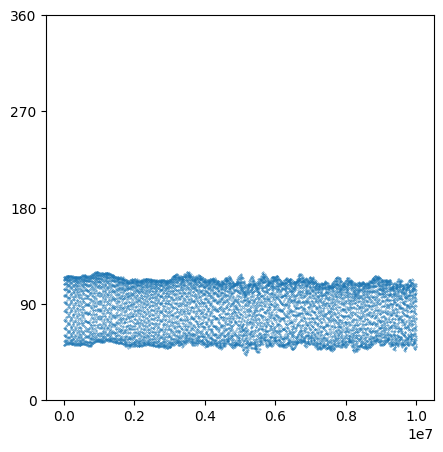

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(np.linspace(0, 1e7,n_out),phi_list[1],s=0.1)
ax.set_ylim(0,360)
ax.set_yticks([0,90,180,270,360]);

# P9

In [3]:
import rebound
import numpy as np
from tqdm import tqdm

# Get L7 Model 
L7_res = pd.read_csv('L7MODEL/resonant.dat',skiprows=28,sep='\s+',header=0)
data = L7_res[L7_res['n1']/L7_res['n2']==2/1] # Asteroid:Neptune resonances


n_out = 10000  # Number of timesteps 
p_len = len(data)
phi_list = np.zeros((p_len,n_out)) # Array with shape [particle_index][timestep]

for it in tqdm(range(p_len)):

    sim = rebound.Simulation()
    sim.G = c.G.value
    sim.units = ('yr', 'AU', 'Msun')
    sim.integrator = "WHFAST"
    sim.dt = 2

    #############################################
    #### Select planets ####
    # For all planets use 'JSUNP', to remove a planet change letter to _
    used_planets = 'JSUN_'
    mask = [char!='_' for char in used_planets]
    #############################################

    sim.add(m=1+5.98e-6)
    masses = [0.00095465,0.00028558,0.00004344,0.00005149,0]
    for i in np.array([0,1,2,3,4])[mask]:
        mass = masses[i]
        elem = orbital_elements[i]
        sim.add(m=mass, a=elem["a"], e=elem["e"], inc=elem["inc"], omega=elem["omega"], Omega=elem["Omega"], f=elem["f"])
    sim.move_to_com()

    # add 2:1 object
    sim.add(m=0,a=list(data['a'])[it],e=list(data['e'])[it],Omega=np.deg2rad(list(data['node'])[it]),inc=np.deg2rad(list(data['i'])[it]),omega=np.deg2rad(list(data['peri'])[it]),M=np.deg2rad(list(data['M'])[it]))
    # add planet 9
    sim.add(m=1.8621634e-5,a=382.4,inc=np.deg2rad(15.6),e=0.2,pomega=np.deg2rad(247.6),Omega=np.deg2rad(97.5))
    particles = sim.particles

    # Integrate the simulation, saving relevant orbital elements

    for i,t in enumerate(np.linspace(0, 1e7,n_out)):
        sim.integrate(t)

        ln              = particles[4].l
        l_particle      = particles[5].l
        pomega_particle = particles[5].pomega

        phi_list[it][i]     = np.rad2deg(2*l_particle-1*ln-pomega_particle)%360
    

100%|██████████| 871/871 [1:34:28<00:00,  6.51s/it]


In [5]:
np.save('p9_21res',phi_list)